In [4]:
import numpy as np
import collections
import os
import matplotlib.pyplot as plt

INFO_FIELDS = ['locus', 'ql', 'mcmc' , 'causality']
class LocusResult(collections.namedtuple('_LocusResult', INFO_FIELDS)):
    __slots__ = ()
    
nloci = 200
nsim = 10
startsim = 0
basedir='/mnt/storage/saikat/work/multivariate-gwas-bayesian-logistic-regression/quasi_laplace_gwas/results/mcmc_vs_qL'
#basedir='/scratch/sbanerj/quasi_laplace_gwas/simulated_phenotype/mcmc_vs_qL'

In [3]:
locusfile = os.path.join(basedir, 'LOCUSNAMES')
with open(locusfile, 'r') as mfile:
    locusprefixes = mfile.readlines()
locusprefixes = [x.strip() for x in locusprefixes]

In [30]:
result = list()

for sim in range(startsim, startsim + nsim):
    simdir = os.path.join( basedir, 'simulations', 'sim{:03d}'.format(sim + 1) )

    causal_file = os.path.join( simdir, 'samples/causal.snplist' )
    
    causal_loci = list()
    with open(causal_file, 'r') as mfile:
        for mline in mfile:
            if mline.startswith('Locus'):
                mline_split = mline.split()
                causal_loci.append(int(mline_split[3]))
                
    for l, locus in enumerate(locusprefixes):
        
        path = 'blore/meta_without_feature/zmax4_muvar_pi0.01_sig0.01/blore_meta_res/{:s}.gen.res'
        outfile = os.path.join( simdir, path.format(locus) )
        with open(outfile, 'r') as mfile:
            mline = next(mfile).strip()
            mline_split = mline.split()
            prob = float(mline_split[2])
        blore_prob = prob
        
        path = 'pimass/c4/output/{:s}.path.txt'
        outfile = os.path.join( simdir, path.format(locus) )
        ntot = 0
        nzero = 0
        with open(outfile, 'r') as mfile:
            next(mfile)
            for mline in mfile:
                nsnps = int(mline.split()[3].strip())
                ntot += 1
                if nsnps > 1:
                    nzero += 1
        mcmc_prob = 1 - float(nzero / ntot)
        
        #path = 'pimass/c4_linear/output/{:s}.path.txt'
        #outfile = os.path.join( simdir, path.format(locus) )
        #ntot = 0
        #nzero = 0
        #with open(outfile, 'r') as mfile:
        #    next(mfile)
        #    for mline in mfile:
        #        nsnps = int(mline.split()[3].strip())
        #        ntot += 1
        #        if nsnps == 0:
        #            nzero += 1
        #mcmc_prob = 1 - float(nzero / ntot)
        
        causality = causal_loci[l]
        mres = LocusResult(locus = locus,
                           ql = blore_prob,
                           mcmc = mcmc_prob,
                           causality = causality)
        result.append(mres)

In [20]:
blore_true = [x.ql   for x in result if x.causality == 1]
bvsr_true  = [x.mcmc for x in result if x.causality == 1]

blore_false = [x.ql   for x in result if x.causality == 0]
bvsr_false  = [x.mcmc for x in result if x.causality == 0]

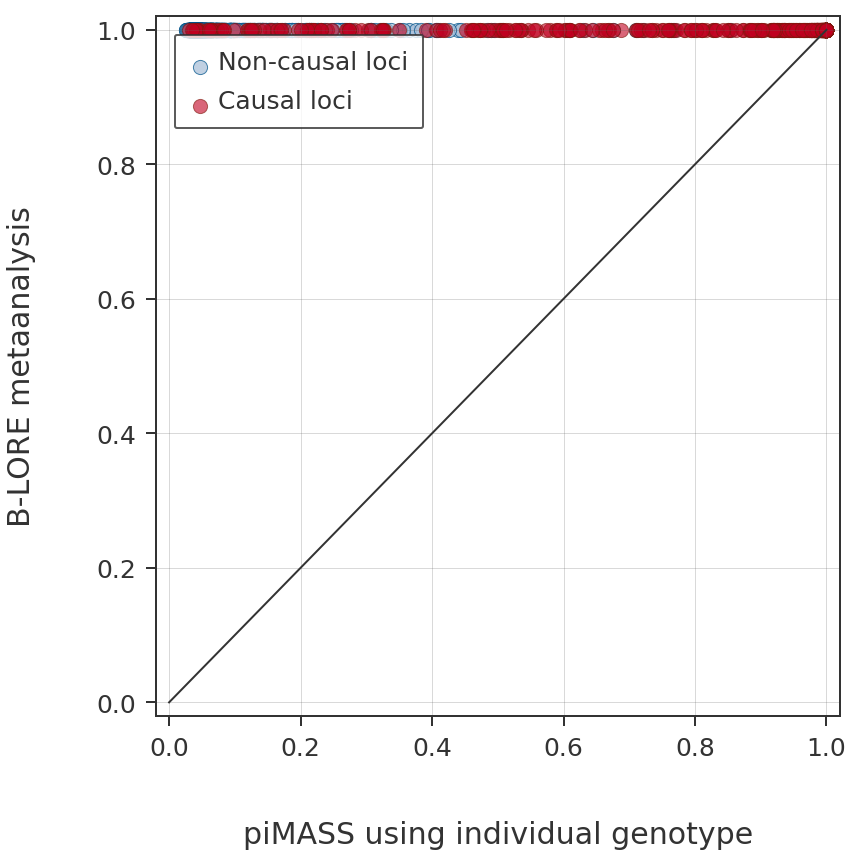

In [21]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray

    # The following don't work well for people with defective color vision
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

bordercolor = '#2B2B2B'
bordercolor = '#333333'
borderwidth = 2
colors = kelly_colors_hex
figsize = (12, 12)
axis_font_size = 30
label_font_size = 25
legend_font_size = 25

fig = plt.figure(figsize = figsize)
ax0 = fig.add_subplot(111) # A big subplot for holding the axis labels

mlabel = "Non-causal loci"
ax0.scatter(bvsr_false, blore_false, color=colors[3], edgecolor=colors[9], s = 200, alpha = 0.7, label = mlabel)

mlabel = "Causal loci"
ax0.scatter(bvsr_true, blore_true, color=colors[4], edgecolor=colors[15], s = 200, alpha = 0.6, label = mlabel)
ax0.plot([0,1], [0,1], lw=borderwidth, color=bordercolor)

mxlabel = r'piMASS using individual genotype'
mylabel = r'B-LORE metaanalysis'
ax0.set_xlabel(mxlabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 60)
ax0.set_ylabel(mylabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 60)

for ax in [ax0]:
    ax.set_ylim(-0.02, 1.02)
    ax.set_xlim(-0.02, 1.02)

    legendtitle = 'SNPs'
    legend = ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
                       scatterpoints = 1,
                       frameon = True, borderpad = 1.5, labelspacing = 1.5
                       #title = legendtitle
                      )
    lframe = legend.get_frame()
    lframe.set_edgecolor(bordercolor)
    lframe.set_linewidth(borderwidth)

    ax.tick_params(axis='both', which = 'major', 
                   length = 10, width = borderwidth, pad=10,
                   labelsize = label_font_size,
                   color = bordercolor,
                   labelcolor = bordercolor,
                   bottom = True, top = False, left = True, right = False
                  )
    for side, border in ax.spines.items():
        border.set_linewidth(borderwidth)
        border.set_color(bordercolor)
    for fonts in ([legend.get_title()] + legend.texts):
        fonts.set_fontsize(legend_font_size)
        fonts.set_color(bordercolor)
    ax.grid(color='dimgray', lw=0.5, alpha=0.5)

plt.tight_layout()
#plt.savefig('pcausal_comparison_probit_mcmc_qL.png', bbox_inches='tight')
#plt.savefig('pcausal_comparison_probit_mcmc_qL.pdf', bbox_inches='tight')
plt.show()

In [25]:
path = 'pimass/c4/output/{:s}.path.txt'
outfile = os.path.join( simdir, path.format(locus) )
ntot = 0
nzero = 0
with open(outfile, 'r') as mfile:
    next(mfile)
    for mline in mfile:
        nsnps = int(mline.split()[3].strip())
        ntot += 1
        if nsnps == 0:
            nzero += 1
blore_prob = 1 - float(nzero / ntot)

In [29]:
mline

'0.176\t0.005\t-1.875\t1\t0.272\t0.063\t0.659\t33.833\t-1.853\t\n'